# Solving a multitraces formulation problem coupled with ordinary differential equations

Code considerations:
- We try to use numpy arrays for faster computations whenever it is possible (lists are very slow).

Import of the numpy library:

In [52]:
import sys
import subprocess

def install_package(package):
    """Intenta instalar un paquete si no está disponible"""
    try:
        __import__(package)
        print(f"✓ {package} ya está instalado")
        return True
    except ImportError:
        print(f"✗ {package} no encontrado. Instalando...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} instalado correctamente")
            return True
        except Exception as e:
            print(f"✗ Error instalando {package}: {e}")
            return False

# Lista de dependencias necesarias
required_packages = {
    'numpy': 'numpy',
    'scipy': 'scipy',
    'matplotlib': 'matplotlib',
    'pyshtools': 'pyshtools'
}

print("Verificando e instalando dependencias...\n")
all_ok = True

for import_name, package_name in required_packages.items():
    if not install_package(import_name):
        all_ok = False

if all_ok:
    print("\nTodas las dependencias están listas")
else:
    print("\nAlgunas dependencias fallaron")
    print("Por favor, ejecuta manualmente en la terminal:")
    print("pip install scipy matplotlib pyshtools")

# Setup de paths
import os
current_dir = os.path.dirname(os.path.abspath('.'))
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)
    print(f"\nPath agregado: {current_dir}")

Verificando e instalando dependencias...

✓ numpy ya está instalado
✓ scipy ya está instalado
✓ matplotlib ya está instalado
✓ pyshtools ya está instalado

Todas las dependencias están listas


Here we solve a example associated with the electropermeabilization problem. See article [Cell Electropermeabilization Modeling via Multiple Traces Formulation and Time Semi-Implicit Coupling](https://arxiv.org/abs/2403.19371) where the model and formulation are described. In this notebook we present one of the simulations of Section 4.3.2 of the same article.

## One sphere

We assume that the center of the sphere is in the origin.

### Parameters set up.

First, we set up the parameters of the problem:

#### Geometry and physical parameters

Radius of the sphere. It has to be a float number:

In [53]:
radius = 10.

The variable `sigmas` is a numpy array with the medium conductivities in the order $\sigma_0$, $\sigma_1$. The numbers have to be floats:

In [54]:
sigma_e = 15. # extracellular conductivity, [microS / micro m]
sigma_i =  1.5  # intracellular conductivity, [microS / micro m]
sigmas = np.asarray([sigma_e, sigma_i])

Capacitance of the membrane (needs to be a float):

In [55]:
c_m = 1.
# c_m = 9.5*10**(-3)  # capacitance [p F / (micro m) ** 2] (This unit is for the Kavian et al. problem)

#### Discretization parameters

Maximum degree of the spherical harmonics to be used for discretize ($L$). It has to be an integer:

In [56]:
big_l = 17

Maximum degree of the spherical harmonics to be used for quadratures ($L_c$). It has to be an integer:

In [57]:
big_l_c = 60

Parameters for the time scheme used:

In [58]:
initial_time = 0.
final_time = 10.
number_steps = 2**13

#### Initial conditions

Set up of initial conditions, for this model we need two arrays of length `(big_l + 1)**2`. Each array has the coefficients of the spherical harmonic expansion of each initial condition.
In the following we give a couple of examples for building one of the arrays:

In [59]:
# Initial condition equal to zero
v_0_zero = np.zeros(((big_l+1)**2))
# Intial condition equal to a cte value
cte = 4.
v_0_cte_value = np.zeros(((big_l+1)**2))
v_0_cte_value[0] = cte * 2* np.sqrt(np.pi)

In this example we use initial conditions equal to zero. We need to set up both arrays in one:

In [60]:
initial_conditions = np.zeros((2, (big_l+1)**2))

#### Set up of the external excitation

Set up the contributions to the right hand side made by $\phi_e$. For this, we set up a function only dependent on time, to account for changes in time. In the module `biosspheres.formulations.mtf.timecouplings.righthands` there are implementations on how to do this. We show some of the predetermined, and how to make a new one:

Pre-defined:

In [ ]:
# ===== CONFIGURACIÓN DE LADOS DERECHOS (φₑ) =====
# Este bloque importa los módulos locales y define las opciones de excitación

import numpy as np

# Importar módulos locales de biosspheres
import biosspheres.formulations.mtf.mtf as mtf
import biosspheres.formulations.mtf.righthands as mtfrighthand
import biosspheres.formulations.massmatrices as mass
import biosspheres.formulations.mtf.timecouplings.righthands as tcrighthands

# Parámetros para las excitaciones
radius_phi = 1.0  
cte = 5.0

print("Módulos locales importados correctamente")
print(f"Configurando excitaciones para: radius={radius_phi}, cte={cte}")

# ===== OPCIONES PREDEFINIDAS =====

print("\n1. Creando phi_cte (constante en espacio y tiempo)...")
phi_cte = tcrighthands.phi_part_of_b_cte_space_and_time(
    big_l, n=1, radii=np.asarray([radius_phi]), cte=cte
)

print("2. Creando phi_point (fuente puntual)...")
phi_point = tcrighthands.phi_part_of_b_point_source_space_and_cte_time(
    big_l, n=1, radii=np.asarray([radius_phi]),
    center_positions=[np.zeros((3))],
    p0 = 25. * np.ones((3)),
    sigma_e = sigmas[0],
    pii = np.asarray([sigmas[1] / sigmas[0]]),
    amplitude = 1.
)

print("3. Creando phi_linear_z (lineal en z, recomendado para Kavian)...")
phi_linear_z = tcrighthands.phi_part_of_b_linear_space_z_cte_time(
    big_l, n=1, radii=np.asarray([radius_phi]),
    center_positions=[np.zeros((3))],
    cte=cte,
    pii=np.asarray([sigmas[1] / sigmas[0]])
)

# ===== OPCIÓN CUSTOM (OPCIONAL) =====
use_custom = False

if use_custom:
    print("\n4. Creando excitación personalizada...")
    n = 1
    ps = [np.zeros((3))]
    radii_custom = np.asarray([radius_phi])
    pii = np.asarray([sigmas[1] / sigmas[0]])
    x_dia, x_dia_inv = mtf.x_diagonal_with_its_inv(n, big_l, radii_custom, pii, azimuthal=False)

    space_phi_linear_z = mtfrighthand.b_vector_n_spheres_mtf_linear_function_z(
        big_l, n, ps, cte, radii_custom, x_dia
    )

    def time_function_pulse(t):
        """Pulso cuadrado: 1 entre t=0 y t=5, 0 fuera"""
        return 1.0 if 0.0 <= t <= 5.0 else 0.0

    custom_phi = tcrighthands.phi_part_of_b_separable_in_space_time(
        space_phi_linear_z, time_function_pulse
    )

# ===== SELECCIÓN DE EXCITACIÓN =====
# Opciones: "cte", "point", "linear_z"
phi_choice = "point" 

phi_map = {
    "cte": phi_cte, 
    "point": phi_point, 
    "linear_z": phi_linear_z
}

if use_custom:
    b_phi_part_time_function = custom_phi
    print(f"\n✓ Usando excitación PERSONALIZADA")
else:
    b_phi_part_time_function = phi_map[phi_choice]
    print(f"\n✓ Usando excitación: '{phi_choice}'")

print("\nConfiguración de excitación completada.")

Módulos locales importados correctamente
Configurando excitaciones para: radius=1.0, cte=5.0

1. Creando phi_cte (constante en espacio y tiempo)...
2. Creando phi_point (fuente puntual)...


AttributeError: module 'biosspheres.utils.validation.inputs' has no attribute 'n_validation'

In [ ]:
# SVD - Snapshots y descomposición

import numpy as np
import os
import time
import matplotlib.pyplot as plt
import biosspheres.formulations.mtf.timecouplings.solvertemplates as solve

out_dir = "results_svd"
os.makedirs(out_dir, exist_ok=True)

# Comprobaciones rápidas
required = ["big_l", "sigmas", "initial_time", "final_time", "number_steps",
            "initial_conditions", "c_m", "i_current", "ode_next_sol"]
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables necesarias en el workspace: {missing}. "
                       "Definelas antes de ejecutar este bloque.")

n_snap_per_sim = 100   # número de snapshots por simulación (aprox)
decimate = max(1, number_steps // n_snap_per_sim)

num = (big_l + 1)**2

phi_labels = []
phi_functions = []

if "phi_cte" in globals():
    phi_labels.append("cte")
    phi_functions.append(phi_cte)
if "phi_point" in globals():
    phi_labels.append("point")
    phi_functions.append(phi_point)
if "phi_linear_z" in globals():
    phi_labels.append("linear_z")
    phi_functions.append(phi_linear_z)
if "custom_phi" in globals():
    phi_labels.append("custom")
    phi_functions.append(custom_phi)

if len(phi_functions) == 0:
    raise RuntimeError("No se encontraron phi_* definidos (phi_cte, phi_point, phi_linear_z o custom_phi).")

print("Se ejecutarán las siguientes opciones de phi:", phi_labels)

snapshot_columns = []
snapshot_metadata = []  # guardar (label, sim_index, time_index) por columna

for lab, phi_fun in zip(phi_labels, phi_functions):
    print(f"\n=== Ejecutando simulación: {lab} ===")
    b_phi_part_time_function = phi_fun

    t0 = time.time()
    solutions = solve.mtf_time_coupling_one_sphere(
        big_l,
        radius,
        sigmas,
        c_m,
        initial_time,
        final_time,
        number_steps,
        initial_conditions,
        b_phi_part_time_function,   # variable corregida
        i_current,
        ode_next_sol,
    )
    dt = time.time() - t0
    print(f"Simulación '{lab}' finalizada en {dt:.1f} s. solutions.shape = {solutions.shape}")

    fname = f"{out_dir}/solutions_{lab}.npy"
    np.save(fname, solutions)
    print(f"Guardado: {fname}")

    try:
        v_all = solutions[:, 4*num:5*num]   # shape (n_time_steps+1, num)
    except Exception as e:
        raise RuntimeError("No se pudo extraer la porción correspondiente a 'v' de `solutions`. "
                           "Revisa el slicing; espero solutions[:, 4*num:5*num].") from e

    for ti in range(0, v_all.shape[0], decimate):
        col = v_all[ti, :].reshape(num)  # vector columna
        snapshot_columns.append(col)
        snapshot_metadata.append((lab, ti, ti * (final_time - initial_time) / number_steps))

A = np.column_stack(snapshot_columns)  # shape (num, Nsnap)
print("\nMatriz de snapshots A.shape =", A.shape)

A_for_svd = A

# Calcular SVD
print("Calculando SVD ... (esto puede tardar si A es grande)")
U, S, Vt = np.linalg.svd(A_for_svd, full_matrices=False)
print("SVD completa. Rangos / primeras singular values:", S[:10])

# Guardar SVD
np.save(os.path.join(out_dir, "snapshots_matrix.npy"), A)
np.save(os.path.join(out_dir, "U.npy"), U)
np.save(os.path.join(out_dir, "S.npy"), S)
np.save(os.path.join(out_dir, "Vt.npy"), Vt)
print(f"Guardados U,S,Vt en {out_dir}/")

# Grafico
plt.figure(figsize=(6,4))
plt.semilogy(S, marker='o')
plt.xlabel('Modo singular $i$')
plt.ylabel('Valor singular $\sigma_i$ (escala log)')
plt.title('Valores singulares de la matriz de snapshots')
plt.grid(True)
plt.tight_layout()
plt.show()

energy = np.cumsum(S**2) / np.sum(S**2)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(S)+1), energy, marker='o')
plt.xlabel('Número de modos retenidos r')
plt.ylabel('Energía acumulada')
plt.title('Energía acumulada por los modos SVD')
plt.axhline(0.99, color='k', linestyle='--', label='99% energía')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# modos 
for tol in [0.95, 0.99, 0.999]:
    r = np.searchsorted(energy, tol) + 1
    print(f"Modos necesarios para {int(tol*100)}% energía: r = {r}")

# Guardar metadata
import json
meta_fname = os.path.join(out_dir, "snapshot_metadata.json")
with open(meta_fname, "w") as f:
    json.dump({"metadata": snapshot_metadata, "phi_labels": phi_labels, "decimate": decimate}, f)
print("Metadata guardada en", meta_fname)

ModuleNotFoundError: No module named 'scipy'

In [ ]:
A_for_svd 

NameError: name 'A_for_svd' is not defined

In [ ]:
# sys.path.append(os.path.abspath(".."))
# # Import of the module where pre-defined right hand sides are.
# import biosspheres.formulations.mtf.timecouplings.righthands as righthands

# # Parámetros fijos para E2
# radius = 1.0
# cte = 5.0

# # phi_e lineal en z, constante en el tiempo (este es el que se usará en E2)
# # phi_point_source_linear = righthands.phi_part_of_b_linear_space_z_cte_time(
#     big_l,
#     n=1,
#     radii=np.asarray([radius]),
#     center_positions=[np.zeros((3))],
#     cte=cte,
#     pii=np.asarray([sigmas[1] / sigmas[0]]),
# )

Custom made:

In [ ]:
# Space part, cte * z_coordinate
import biosspheres.formulations.mtf.mtf as mtf
import biosspheres.formulations.mtf.righthands as mtfrighthand

# Parameters for the function
n=1
radii=np.asarray([radius])
cte = 5.
ps =[np.zeros((3))]
pii = np.asarray([sigmas[1]/sigmas[0]])
x_dia, x_dia_inv = mtf.x_diagonal_with_its_inv(
        n, big_l, radii, pii, azimuthal=False
    )
# Pre-defined space part
space_phi = mtfrighthand.b_vector_n_spheres_mtf_linear_function_z(
    big_l, n, ps, cte, radii, x_dia)

# Time part, custom made
def time_function(time):
  if time >= 5. or time < 0:
    return 0.
  else:
    return 1.


custom_phi = righthands.phi_part_of_b_separable_in_space_time(space_phi, time_function)

b_phi_part_time_function = custom_phi

#### Parameters for the coupled currents and ordinary differential equations:

For Kavian et al. dynamics:

In [ ]:
s_l = 1.9*10**(-6)  # [micro S / (micro m) ** 2]
s_ir = 2.5*10**2  # [micro S / (micro m) ** 2]
tau_ep = 1.  # [micro s]
tau_res = 10.**3  # [micro s]
k_ep = 40.  # [V ** -1]
v_rev = 1.5  # [V]

### Set up of internals

Set up of the time steps:

In [ ]:
# ===== CONFIGURACIÓN DEL TIEMPO =====

import biosspheres.formulations.mtf.timecouplings.solvertemplates as solve

tau, times, medium_times = solve.tau_times_medium(
    initial_time, final_time, number_steps
)
print(f"Paso de tiempo (tau): {tau}")
print(f"Número de pasos: {number_steps}")
print(f"Tiempo final: {final_time}")

### Set up of the coupled problem

Set up of the non linear current. Different models for the current can be used, there are models ready to use in the module `biosspheres.miscella.forcouplings.currents`. See the internals of the module for making custom made currents.

In [ ]:
# ===== IMPORTAR MÓDULOS PARA CORRIENTES Y ODEs =====

import biosspheres.miscella.forcouplings.currents as currents
import biosspheres.miscella.forcouplings.oderesolutions as oderesolutions

print("Módulos de corrientes y ODEs importados correctamente")

Kavian et al. current:

In [ ]:
i_current_kavian = currents.i_kavian_leguebe_ea_2014_1_sphere_2d(big_l, big_l_c, radius, s_l, s_ir)

In [ ]:
ode_next_sol_kavian = oderesolutions.next_step_z_kavian_leguebe_ea_2014_2d(big_l, big_l_c, tau, tau_ep, tau_res, k_ep, v_rev)

Model to be used:

In [ ]:
i_current = i_current_kavian
ode_next_sol = ode_next_sol_kavian

### Solving

First, we set up internal parameters used for requirements of numpy for threading:

In [ ]:
import os
number = "7" # Maximum of threads
os.environ["OMP_NUM_THREADS"] = number
os.environ["OPENBLAS_NUM_THREADS"] = number
os.environ["MKL_NUM_THREADS"] = number
os.environ["VECLIB_MAXIMUM_THREADS"] = number
os.environ["NUMEXPR_NUM_THREADS"] = number

We implemented a direct solver (LU decomposition) that takes as parameters what we previously defined, including the current and the coupled ODE system. The complete list can be seen in the following:

In [ ]:
solutions = solve.mtf_time_coupling_one_sphere(
	big_l,
	radius,
	sigmas,
	c_m,
	initial_time,
	final_time,
	number_steps,
	initial_conditions,
	b_phi_part_time_function,
	i_current,
	ode_next_sol,
)

Notice that the functions is defined in the module `biosspheres.formulations.mtf.timecouplings.solvertemplates` shortened in `solve`

### Saving the results

The following saves all solutions, i.e. traces, transmembrane potential, and recovery variables, in numpy format. We have commented the line for the saving.

In [ ]:
filename="example.npy"
directory=""
# np.save(directory+filename, solutions)

To load the solutions:

In [ ]:
# solutions = np.load(directory+filename)

To save in `txt` format:

In [ ]:
filename="example.txt"
directory=""
# np.savetxt(directory+filename, solutions)

To load the solutions:

In [ ]:
# solutions = np.loadtxt(directory+filename)

### Plotting the results

For plotting the evolution of time of the solutions evaluated in the north pole of the sphere:

In [ ]:
# ===== VISUALIZACIÓN: Evolución temporal en el polo norte =====

import matplotlib.pyplot as plt
import biosspheres.utils.auxindexes as auxindexes

num = (big_l + 1)**2
eles, l_square_plus_l, el_square_plus_el_divided_by_two = (
    auxindexes.eles_combination(big_l)
)
little_partial_spherical = np.sqrt((2 * eles + 1))

plt.figure(figsize=(10, 6))
plt.plot(
    times,
    np.sum(
        solutions[:, (4 * num + l_square_plus_l[0 : big_l + 1])]
        * little_partial_spherical[0 : big_l + 1],
        axis=1,
    )
    / (2.0 * np.sqrt(np.pi)),
    label="Solución numérica",
    marker=".",
)
plt.xlabel('Tiempo')
plt.ylabel('Potencial transmembrana (v)')
plt.title('Evolución temporal del potencial transmembrana en el polo norte')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Additional variable')

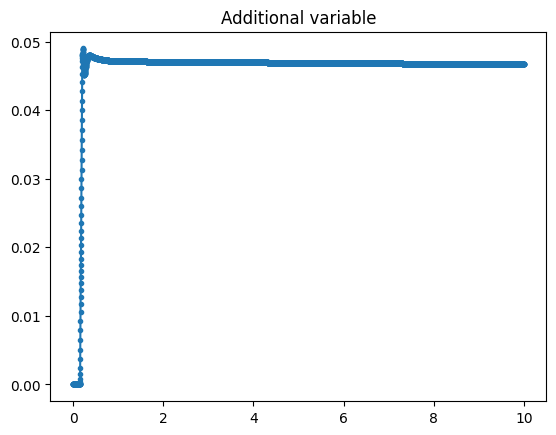

In [ ]:
plt.figure()
little_partial_spherical = np.sqrt((2 * eles + 1))
plt.plot(
	times,
	np.sum(
		solutions[:, (5 * num + l_square_plus_l[0 : big_l + 1])]
		* little_partial_spherical[0 : big_l + 1],
		axis=1,
	)
	/ (2.0 * np.sqrt(np.pi)),
	label="Numerical solution",
	marker=".",
)
plt.title("Additional variable")

For plotting the transmembrane potential on the surface of the sphere at a given time:

In [ ]:
# ===== PREPARAR CUADRATURAS PARA VISUALIZACIÓN 3D =====

import biosspheres.quadratures.sphere as quadratures

(
    quantity_theta_points,
    quantity_phi_points,
    weights,
    pre_vector,
    spherical_harmonics,
) = quadratures.gauss_legendre_trapezoidal_real_sh_mapping_2d(
    big_l, big_l_c
)

print(f"Puntos theta: {quantity_theta_points}")
print(f"Puntos phi: {quantity_phi_points}")
print("Cuadraturas preparadas correctamente")

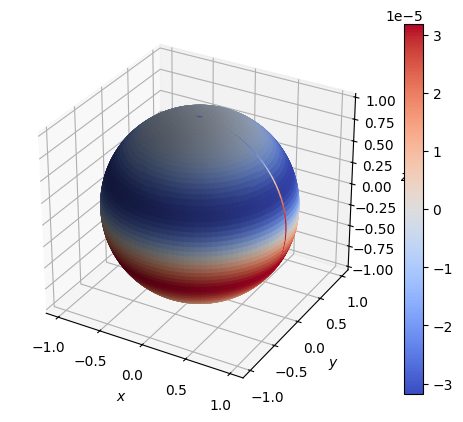

In [ ]:
time_index = 3 * number_steps // 4  # time index of the simulation 
vector = pre_vector * radius
surface_v = np.zeros((quantity_theta_points, quantity_phi_points))
surface_v[:, :] = np.sum(
	solutions[time_index, 4 * num:5*num, np.newaxis, np.newaxis]
	* spherical_harmonics, axis=0)
surface_v_max = np.max(np.abs(surface_v))
surface_v = (surface_v + surface_v_max) / (2. * surface_v_max)

from matplotlib import cm, colors
fig = plt.figure()
ax_1 = fig.add_subplot(111, projection='3d')
ax_1.plot_surface(
	vector[0, :, :],
	vector[1, :, :],
	vector[2, :, :],
	rstride=1, cstride=1, 
	facecolors=cm.coolwarm(surface_v[:, :]))
ax_1.set_xlabel('$x$')
ax_1.set_ylabel('$y$')
ax_1.set_zlabel('$z$')
ax_1.set_aspect('equal')
fig.colorbar(cm.ScalarMappable(
    norm=colors.CenteredNorm(halfrange=surface_v_max), cmap=cm.coolwarm),
    ax=ax_1)

That can be made a video too.

For plotting a plane cut without $\phi_e$:

In [ ]:
# ===== VISUALIZACIÓN: Corte plano sin φₑ =====

import biosspheres.laplace.drawing as draw
from matplotlib import cm, colors

cut = 1  # Corte en el plano YZ (x=0)

# Tamaño de la ventana a plotear
horizontal = 5.
vertical = 5.

# Resolución del plot
inter_horizontal = 100
inter_vertical = 100

# Función cero para plotear sin la función externa
def zero(x: np.ndarray) -> float:
    return 0.

# Índice de tiempo para visualizar
time_index = 3 * number_steps // 4

x1, y1, data = draw.draw_cut_representation_formula_one_sphere_azimuthal_symmetry(
    cut, np.zeros((3)), horizontal, vertical, inter_horizontal, inter_vertical, 
    solutions[time_index, 0 : 4 * num], radius, big_l, zero
)

plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower',
           extent=[-horizontal / 2, horizontal / 2,
                   -vertical / 2, vertical / 2],
           norm=colors.CenteredNorm(),
           cmap='RdBu_r'
           )
plt.xlabel('$y$')
plt.ylabel('$z$')
plt.title(f'Corte en $x = 0$ (tiempo index={time_index})')
plt.colorbar(label='Potencial')
plt.grid(True, alpha=0.3)
plt.show()